In [1]:
import wrf
import netCDF4 as nc
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pyart
import datetime as dt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [2]:
#Load the WRF simulation output. Currently, the standard wrfout files are hourly, whereas the highres files are 10-minute, but only contain surface winds
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04*"))]


In [8]:
def get_base_state():
    #Get base states for perturbation calculations
    #Define base state as the horzontal average of all hourly times before the event (03:30)
    
    ## Testing:
    # base1 = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-15_15:00:00")
    # base2 = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-15_23:00:00")
    # base3 = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_03:00:00")
    # base4 = nc.Dataset("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-16_06:00:00")
    # wrf.getvar(base1,"T").sel(bottom_top=range(0,50,1)).mean(("west_east","south_north")).plot(y="bottom_top",label="15th 1500")
    # wrf.getvar(base2,"T").sel(bottom_top=range(0,50,1)).mean(("west_east","south_north")).plot(y="bottom_top",label="15th 2300")
    # wrf.getvar(base3,"T").sel(bottom_top=range(0,50,1)).mean(("west_east","south_north")).plot(y="bottom_top",label="16th 0300")
    # wrf.getvar(base4,"T").sel(bottom_top=range(0,50,1)).mean(("west_east","south_north")).plot(y="bottom_top",label="16th 0600")
    # plt.legend()
    
    initial_time = dt.datetime(2023,10,15,15)
    times = []
    while initial_time <= dt.datetime(2023,10,16,12):
        times.append(initial_time.strftime("%Y-%m-%d_%H:%M:%S"))
        initial_time = initial_time+dt.timedelta(hours=1)
        
    path = "/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_"
    
    
    base = [nc.Dataset(path+times[t]) for t in range(len(times))]
    T_base = wrf.getvar(base,"T",timeidx=wrf.ALL_TIMES).mean(("west_east","south_north","Time"))
    theta_base = wrf.getvar(base,"theta",timeidx=wrf.ALL_TIMES).mean(("west_east","south_north","Time"))
    p_base = wrf.getvar(base,"p",timeidx=wrf.ALL_TIMES).mean(("west_east","south_north","Time"))
    qv_base = wrf.getvar(base,"QVAPOR",timeidx=wrf.ALL_TIMES).mean(("west_east","south_north","Time"))
    
    return T_base, theta_base, p_base, qv_base


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/plot/accessor.py:1190: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  return dataset_plot.quiver(self._ds, *args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/plot/accessor.py:1190: DeprecationWarning: Using positional arguments is deprecated for plot methods, use keyword arguments instead.
  return dataset_plot.quiver(self._ds, *args, **kwargs)


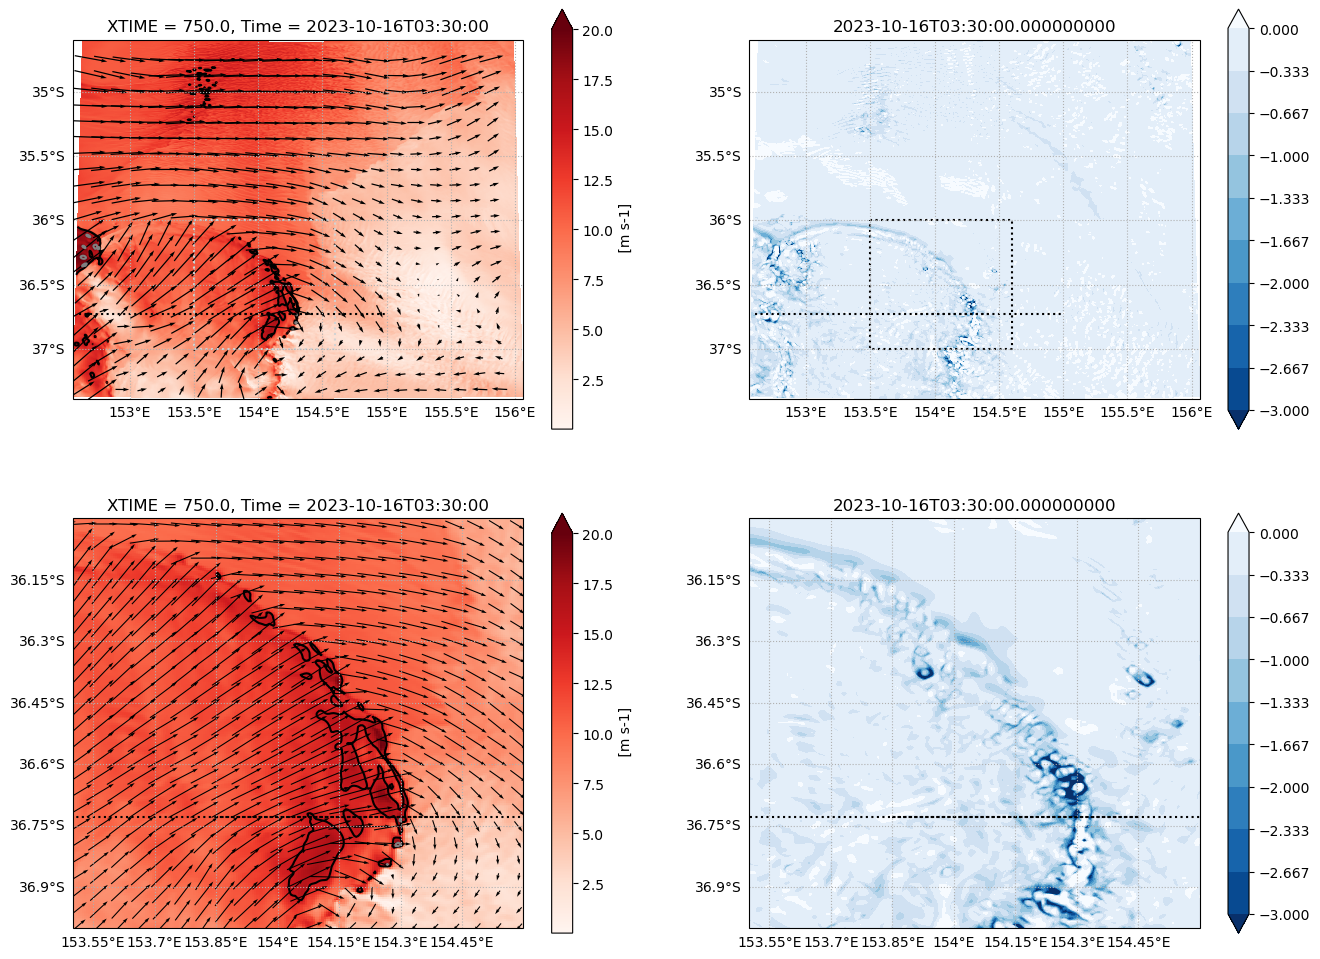

In [5]:
def plot(file_list,v,t_ind,ax,levels=None,cmap=None,lev=None,vmax=None):
    
    #Code to plot lat-lon contours of various quantities
    
    if v == "REFL_10CM":
        p1 = wrf.getvar(file_list, v, timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.max("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    elif v == "THETA":
        p1 = wrf.getvar(file_list, "theta", timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)      
    elif v == "THETA-E":
        p1 = wrf.getvar(file_list, "theta_e", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)              
    elif v == "W_MIN":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind)
        time=p1.Time.values
        p1 = xr.where(heights < 5000, p1, np.nan)
        c=xr.plot.contourf(p1.min("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    elif v == "W":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values
        p1 = wrf.interplevel(p1,heights,lev)
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)                
    elif v == "WS10":
        p1 = wrf.getvar(file_list, "U10", timeidx=t_ind)
        time=p1.Time.values
        p2 = wrf.getvar(file_list, "V10", timeidx=t_ind)
        p=np.sqrt(p1**2+p2**2)
        p.attrs=p1.attrs
        c=xr.plot.pcolormesh(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap,vmax=vmax)
        c=xr.plot.contour(p,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=[15,20],colors=["k","grey"])    
    elif v == "W_DN_MAX":
        p1 = wrf.getvar(file_list, v, timeidx=t_ind)
        time=p1.Time.values
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    else:
        p1 = wrf.getvar(file_list, v, timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    plt.title(time)
    
#PLOT THETA WITH TRANSECT
t_ind = 12*6 + 3


lons1 = [153.85,154.45]
lats1 = [-36.73,-36.73]
# lons2 = [154.0,154.45]
# lats2 = [-36.73,-36.65]
lons2 = [152.6,155.0]
lats2 = [-36.73,-36.73]

xlim = [153.5,154.6]
ylim = [-37,-36]

coarsen=30

plt.figure(figsize=[16,12])
ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
#ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"WS10",t_ind,ax,levels=None,cmap=plt.get_cmap("Reds"),vmax=20)
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.getvar(wrflist,"U10",timeidx=t_ind)
v=wrf.getvar(wrflist,"V10",timeidx=t_ind)
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":coarsen,"west_east":coarsen},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]], [ylim[1],ylim[1],ylim[0],ylim[0],ylim[1]], color="lightgrey", ls=":")

#PLOT W WITH TRANSECT
ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
#ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W_MIN",t_ind,ax,levels=np.linspace(-3,0,10),cmap=plt.get_cmap("Blues_r"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]], [ylim[1],ylim[1],ylim[0],ylim[0],ylim[1]], color="k", ls=":")


coarsen=10

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"WS10",t_ind,ax,levels=None,cmap=plt.get_cmap("Reds"),vmax=20)
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":coarsen,"west_east":coarsen},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

#PLOT W WITH TRANSECT
ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W_MIN",t_ind,ax,levels=np.linspace(-3,0,10),cmap=plt.get_cmap("Blues_r"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons1, lats1, color="k",ls=":")
ax.plot(lons2, lats2, color="k",ls=":")

In [9]:
T_base, theta_base, p_base, qv_base = get_base_state()

In [10]:
theta = wrf.getvar(wrflist,"theta",timeidx=t_ind)
theta_pert = theta - theta_base
T = wrf.getvar(wrflist,"T",timeidx=t_ind)
thetae = wrf.getvar(wrflist,"theta_e",timeidx=t_ind)
heights = wrf.getvar(wrflist,"z",timeidx=t_ind)
P = wrf.getvar(wrflist,"p",timeidx=t_ind)
p_pert = P - p_base
U = wrf.getvar(wrflist,"U",timeidx=t_ind)
V = wrf.getvar(wrflist,"V",timeidx=t_ind)
QR = wrf.getvar(wrflist,"QRAIN",timeidx=t_ind)
QC = wrf.getvar(wrflist,"QCLOUD",timeidx=t_ind)
QV = wrf.getvar(wrflist,"QVAPOR",timeidx=t_ind)
QI = wrf.getvar(wrflist,"QICE",timeidx=t_ind)
W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)

In [11]:
B = 9.8 * ( (theta_pert / theta_base) + 0.61*(QV - qv_base) - (QC + QR + QI) )

In [12]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def set_km_tick_labels(ax,cross,lats,lons):
    
    xy_lats = [xy.lat for xy in cross.xy_loc.values]
    xy_lons = [xy.lon for xy in cross.xy_loc.values]
    xy_xticklabs = np.round(latlon_dist(lats[0],lons[0],xy_lats,xy_lons),1).astype(str)
    tick_number = np.floor(qr_cross.cross_line_idx.shape[0] / 8).astype(int)
    ax.set_xticks(np.arange(0,qr_cross.cross_line_idx.shape[0],tick_number),xy_xticklabs[np.arange(0,qr_cross.cross_line_idx.shape[0],tick_number)],rotation=0)
    ax.set_xlabel("Along-transect distance (km)")

In [47]:
lats = lats1
lons = lons1
    
start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=12000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
theta_pert_cross = wrf.vertcross(theta_pert,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
t_cross = wrf.vertcross(T,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
b_cross = wrf.vertcross(B,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
thetae_cross = wrf.vertcross(thetae,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point,latlon=True)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(50,top,100),start_point=start_point,end_point=end_point,)

#https://en.wikipedia.org/wiki/Rotation_of_axes_in_two_dimensions
uu_cross = np.cos(angle) * u_cross + np.sin(angle) * v_cross
vv_cross = (-np.sin(angle) * u_cross) + np.cos(angle) * v_cross

#REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
dbz = wrf.getvar(wrflist,"dbz",timeidx=t_ind).persist().squeeze()
refl_cross = wrf.vertcross(dbz,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

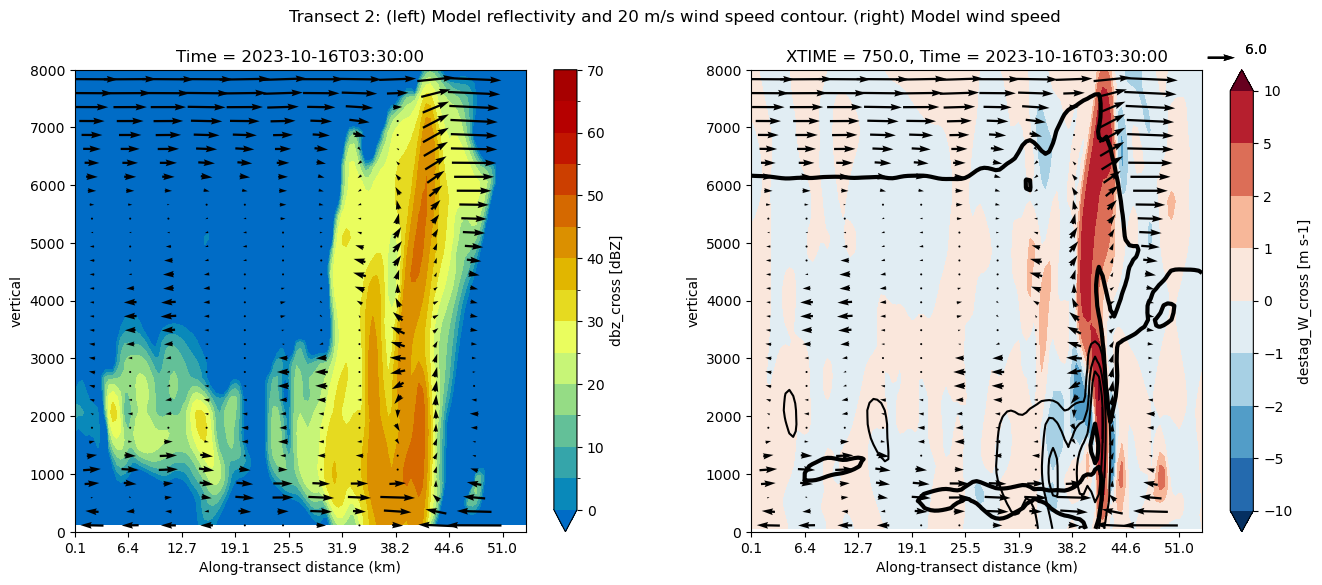

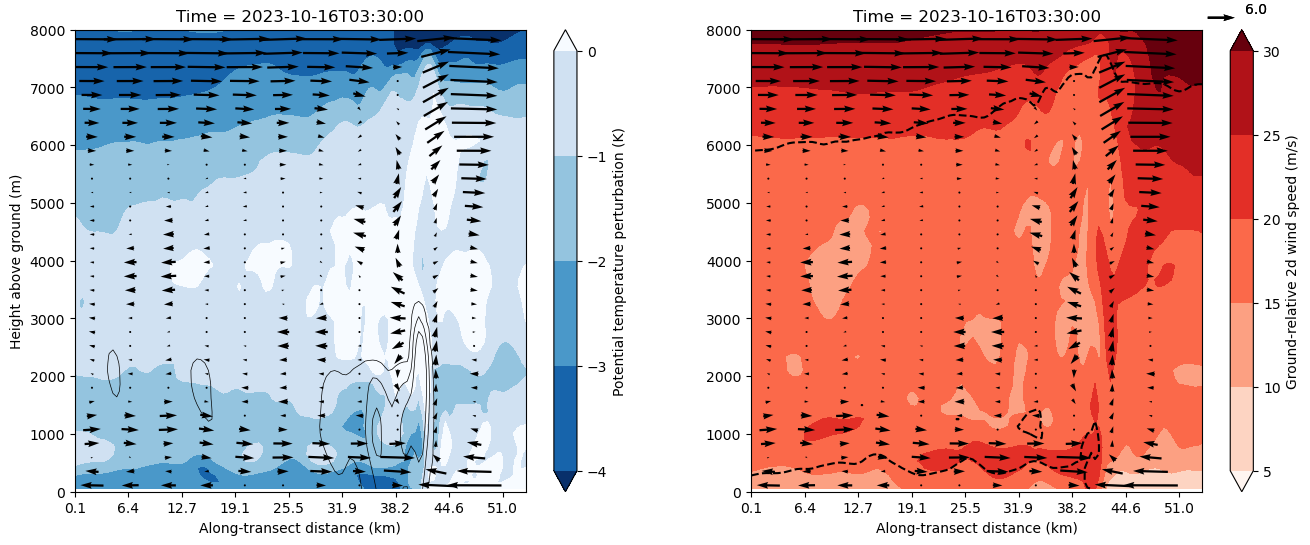

In [59]:
y2=8000
mean_motion_top=6000
scale=100
vert_step=2
width=0.005

plt.figure(figsize=[16,6])

plt.subplot(1,2,1)

wind_transect = xr.Dataset({"uu":uu_cross,"w":w_cross}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean = wind_transect.sel({"vertical":slice(0,mean_motion_top)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
#xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="pink",linewidths=3)
#xr.plot.contour(w_cross,levels=[-2,2],colors="k")
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 2: (left) Model reflectivity and 20 m/s wind speed contour. (right) Model wind speed");
plt.subplot(1,2,2)
xr.plot.contourf(w_cross,levels=[-10,-5,-2,-1,0,1,2,5,10],extend="both")
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),colors="k",levels=[20],linewidths=3)
xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k")
plt.ylim([0,y2])
#xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="k",linewidths=3)
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)


plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
#xr.plot.contour(theta_pert_cross,colors="k",levels=[-4.5,-4,-3.5,-3,-2.5,-2],linewidths=1)
xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k",linewidths=0.5)
c=xr.plot.contourf(theta_pert_cross,cmap="Blues_r",levels=[-4,-3,-2,-1,0],vmax=0,add_colorbar=False)
cb=plt.colorbar(c); cb.set_label("Potential temperature perturbation (K)")
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

plt.subplot(1,2,2)
c=xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap="Reds",add_colorbar=False,levels=[5,10,15,20,25,30])
cb=plt.colorbar(c); cb.set_label("Ground-relative 2d wind speed (m/s)")
xr.plot.contour(theta_pert_cross,colors="k",levels=[-2])
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wrf_theta_windspeed_cross_section.jpeg",dpi=400,bbox_inches="tight")

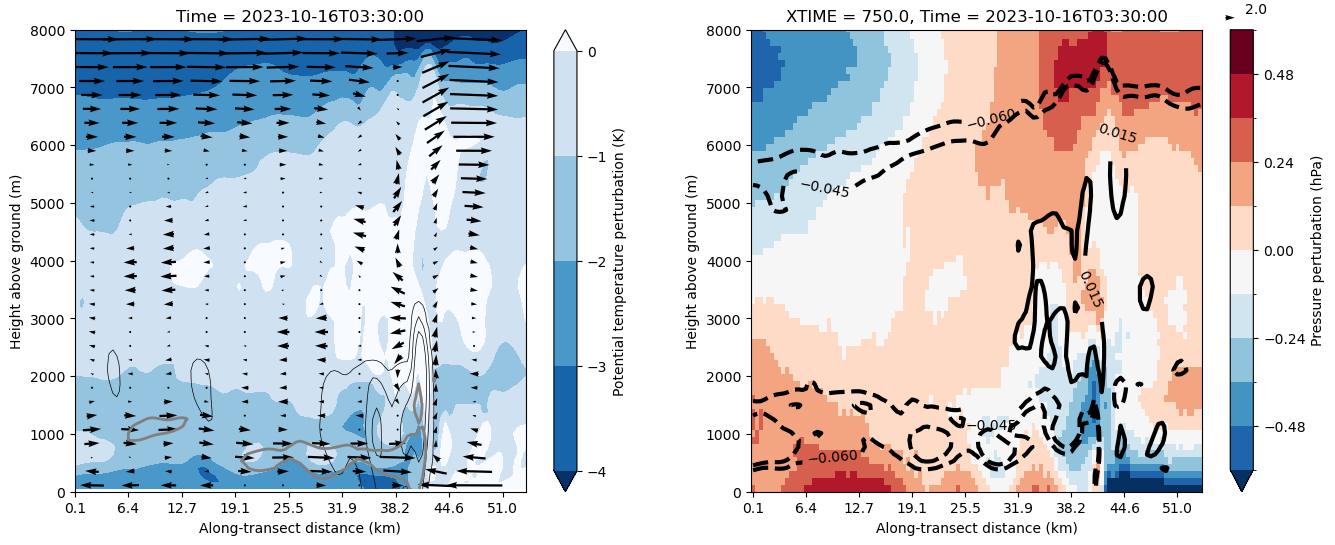

In [66]:
plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
#xr.plot.contour(theta_pert_cross,colors="k",levels=[-4.5,-4,-3.5,-3,-2.5,-2],linewidths=1)
xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k",linewidths=0.5)
c = xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))).sel(vertical=slice(0,2000)),colors="grey",levels=[20],linewidths=2)
c=xr.plot.contourf(theta_pert_cross,cmap="Blues_r",levels=[-4,-3,-2,-1,0],vmax=0,add_colorbar=False)
cb=plt.colorbar(c); cb.set_label("Potential temperature perturbation (K)")
wind_transect.sel(vertical=slice(0,8000)).drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=None,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

plt.subplot(1,2,2)
c = ((p_cross - p_cross.mean("cross_line_idx"))/100).plot(levels=np.linspace(-.6,.6,11),alpha=1,add_colorbar=False)
cb = plt.colorbar(c); cb.set_label("Pressure perturbation (hPa)")
# wind_transect.drop_vars("xy_loc")\
#         .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
#         .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
c = xr.plot.contour(b_cross,levels=[-0.06,-0.045,0.015],colors="k",linewidths=3) 
plt.clabel(c)
plt.ylim([0,8000])
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wrf_theta_perssure_cross_section.jpeg",dpi=400,bbox_inches="tight")

Text(0, 0.5, 'Height above ground (m)')

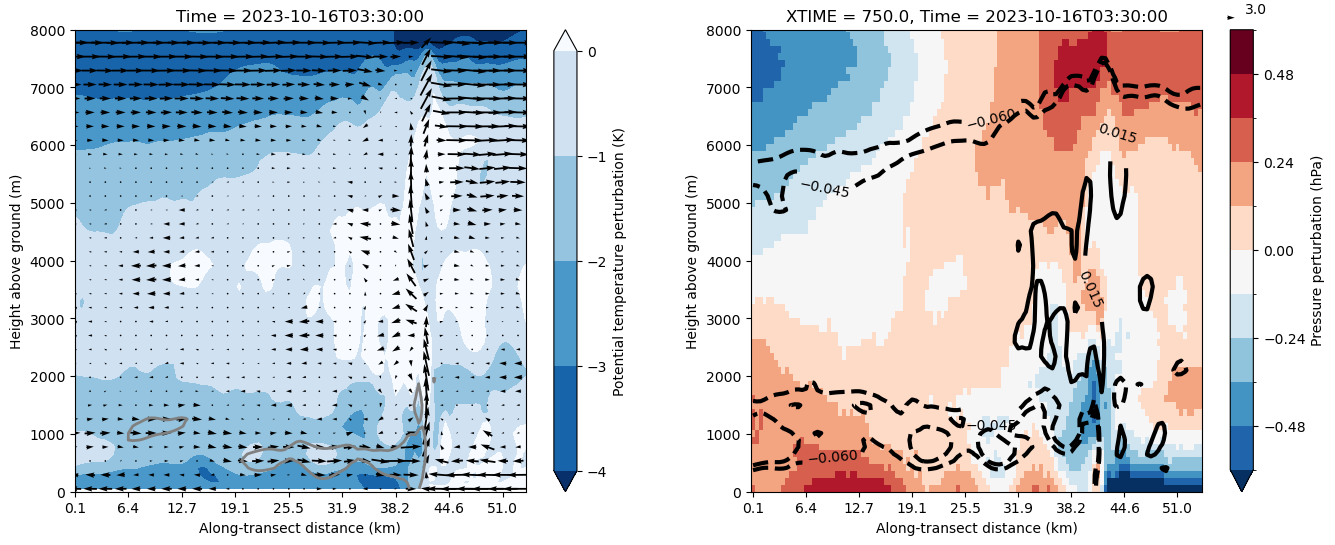

In [74]:
plt.figure(figsize=[16,6])

horiz_step = 4
width=0.004

plt.subplot(1,2,1)
#xr.plot.contour(theta_pert_cross,colors="k",levels=[-4.5,-4,-3.5,-3,-2.5,-2],linewidths=1)
#xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k",linewidths=0.5)
c = xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))).sel(vertical=slice(0,2000)),colors="grey",levels=[20],linewidths=2)
c=xr.plot.contourf(theta_pert_cross,cmap="Blues_r",levels=[-4,-3,-2,-1,0],vmax=0,add_colorbar=False)
cb=plt.colorbar(c); cb.set_label("Potential temperature perturbation (K)")
wind_transect.sel(vertical=slice(0,8000)).drop_vars("xy_loc")\
        .isel(cross_line_idx=slice(0,-1,horiz_step),vertical=slice(0,-1,vert_step))\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=None,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

plt.subplot(1,2,2)
c = ((p_cross - p_cross.mean("cross_line_idx"))/100).plot(levels=np.linspace(-.6,.6,11),alpha=1,add_colorbar=False)
cb = plt.colorbar(c); cb.set_label("Pressure perturbation (hPa)")
# wind_transect.drop_vars("xy_loc")\
#         .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
#         .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
c = xr.plot.contour(b_cross,levels=[-0.06,-0.045,0.015],colors="k",linewidths=3) 
plt.clabel(c)
plt.ylim([0,8000])
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

#plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wrf_theta_perssure_cross_section.jpeg",dpi=400,bbox_inches="tight")

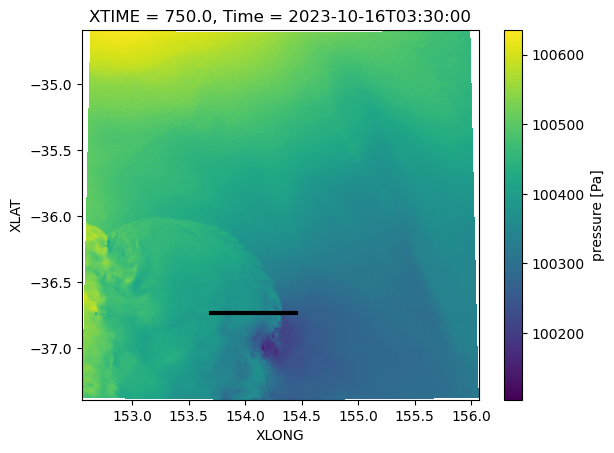

In [15]:
P.isel(bottom_top=0).plot(x="XLONG",y="XLAT")
plt.plot(lons1, lats1, color="k",ls="-",lw=3)

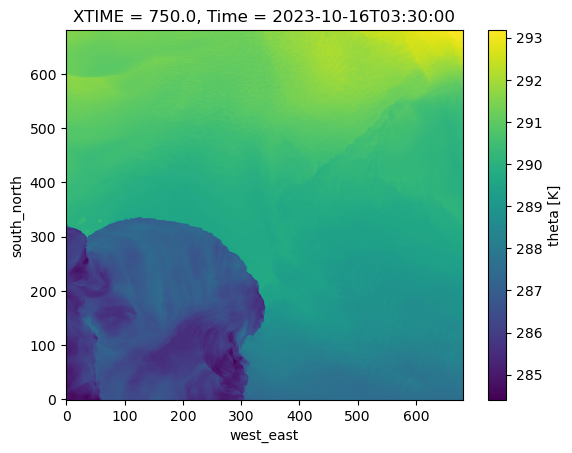

In [16]:
theta.isel(bottom_top=0).plot()

In [44]:
lats = lats2
lons = lons2

start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))

top=12000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
theta_pert_cross = wrf.vertcross(theta_pert,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
thetae_cross = wrf.vertcross(thetae,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_cross = wrf.vertcross(P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
p_pert_cross = wrf.vertcross(p_pert,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

#REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
dbz = wrf.getvar(wrflist,"dbz",timeidx=t_ind).persist().squeeze()
refl_cross = wrf.vertcross(dbz,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

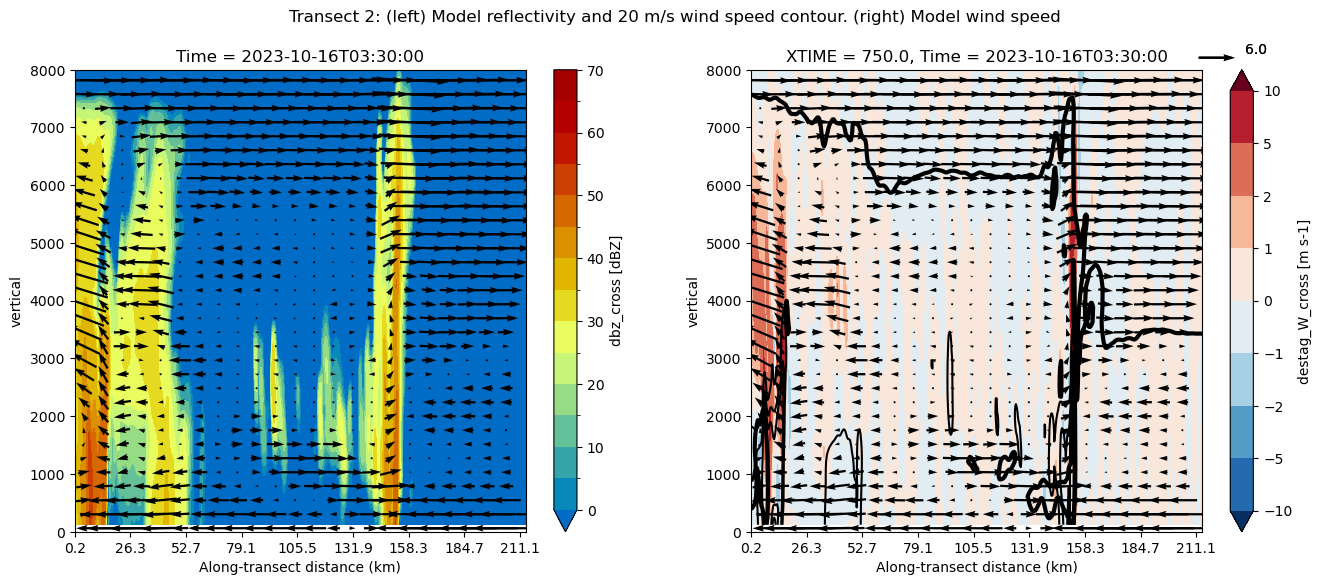

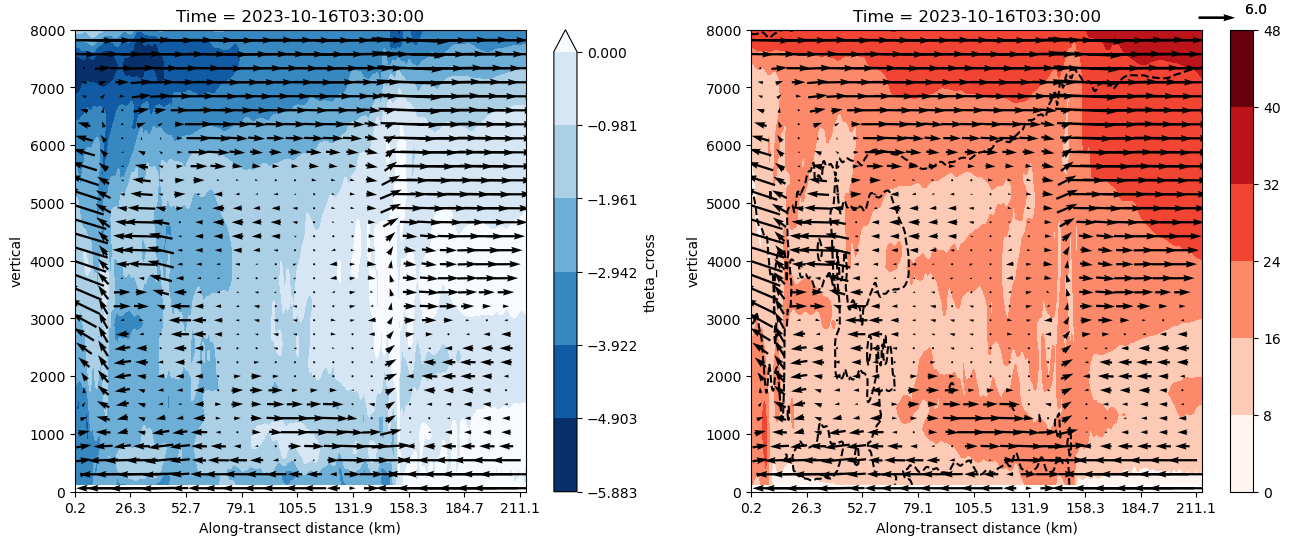

In [45]:
y2=8000
mean_motion_top=6000
scale=75
vert_step=2
horiz_step=20
width=0.005

plt.figure(figsize=[16,6])

plt.subplot(1,2,1)

wind_transect = xr.Dataset({"uu":uu_cross,"w":w_cross}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})
umean = wind_transect.sel({"vertical":slice(0,mean_motion_top)}).uu.mean()
wind_transect["uu"] = wind_transect.uu - umean

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":horiz_step,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
#xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="pink",linewidths=3)
#xr.plot.contour(w_cross,levels=[-2,2],colors="k")
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.suptitle("Transect 2: (left) Model reflectivity and 20 m/s wind speed contour. (right) Model wind speed");
plt.subplot(1,2,2)
xr.plot.contourf(w_cross,levels=[-10,-5,-2,-1,0,1,2,5,10],extend="both")
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":horiz_step,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),colors="k",levels=[20],linewidths=3)
xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k")
plt.ylim([0,y2])
#xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="k",linewidths=3)
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)


plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
#xr.plot.contour(theta_pert_cross,colors="k",levels=[-4.5,-4,-3.5,-3,-2.5,-2])
xr.plot.contourf(theta_pert_cross,cmap="Blues_r",vmax=0)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":horiz_step,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

plt.subplot(1,2,2)
xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap="Reds")
xr.plot.contour(theta_pert_cross,colors="k",levels=[-2])
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":horiz_step,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)

Text(0, 0.5, 'Height above ground (m)')

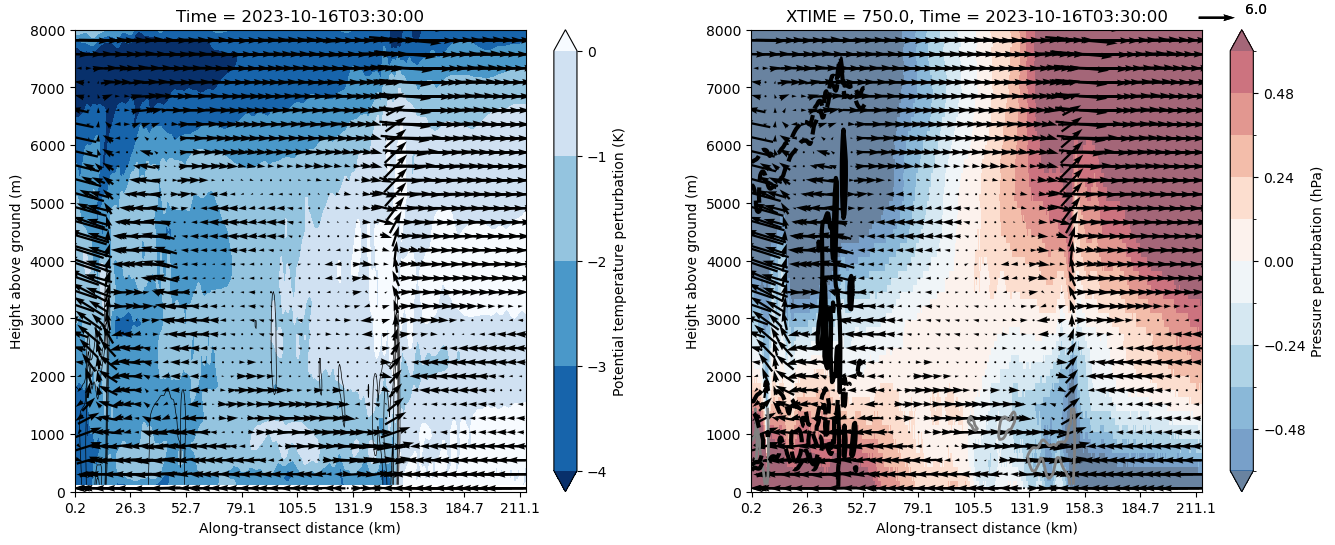

In [46]:
plt.figure(figsize=[16,6])

plt.subplot(1,2,1)
#xr.plot.contour(theta_pert_cross,colors="k",levels=[-4.5,-4,-3.5,-3,-2.5,-2],linewidths=1)
xr.plot.contour(qr_cross*1000,levels=[0.1,0.5,1],colors="k",linewidths=0.5)
c=xr.plot.contourf(theta_pert_cross,cmap="Blues_r",levels=[-4,-3,-2,-1,0],vmax=0,add_colorbar=False)
cb=plt.colorbar(c); cb.set_label("Potential temperature perturbation (K)")
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")

plt.subplot(1,2,2)
c = ((p_cross - p_cross.mean("cross_line_idx"))/100).plot(levels=np.linspace(-.6,.6,11),alpha=0.6,add_colorbar=False)
cb = plt.colorbar(c); cb.set_label("Pressure perturbation (hPa)")
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":10,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)
c = xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))).sel(vertical=slice(0,1500)),colors="grey",levels=[20],linewidths=2)
c = xr.plot.contour(b_cross,levels=[-0.06,-0.045,0.015],colors="k",linewidths=3) 
#plt.clabel(c)
plt.ylim([0,8000])
plt.ylim([0,y2])
set_km_tick_labels(plt.gca(),qr_cross,lats,lons)
plt.ylabel("Height above ground (m)")


In [38]:
P = wrf.getvar(wrflist,"P",timeidx=t_ind)
test_base = P.mean(("west_east","south_north"))

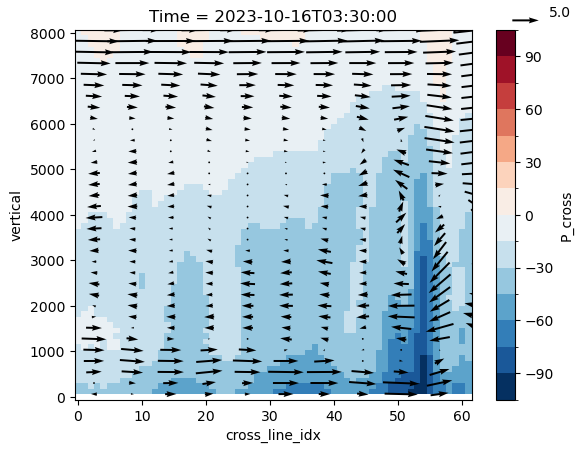

In [43]:
test_P = (P-test_base)
test_P_cross = wrf.vertcross(test_P,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
test_P_cross.sel(vertical=slice(0,8000),cross_line_idx=slice(0,62)).plot(levels=20)
wind_transect.drop_vars("xy_loc")\
        .coarsen(dim={"cross_line_idx":horiz_step,"vertical":vert_step},boundary="trim").mean()\
        .plot.quiver(x="cross_line_idx",y="vertical",u="uu",v="w",scale=scale,width=width)

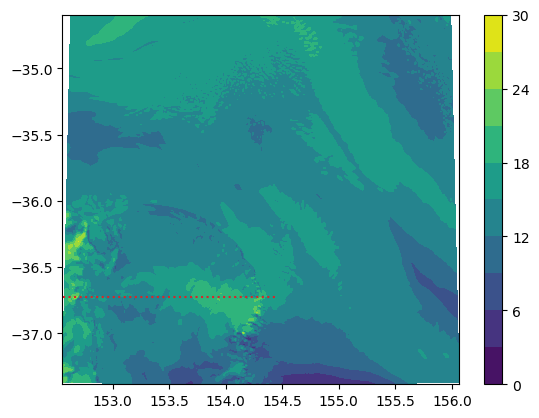

In [46]:
U1000 = wrf.interplevel(wrf.destagger(U,2),heights,1000)
V1000 = wrf.interplevel(wrf.destagger(V,1),heights,1000)
plt.contourf(theta.XLONG.values,theta.XLAT.values,np.sqrt(U1000**2 + V1000**2),levels=8); plt.colorbar()
plt.plot(lons2, lats2, color="tab:red",ls=":")

In [48]:
P.XLONG.min()

<xarray.DataArray 'XLONG' ()>
array(152.55615234)
Coordinates:
    XTIME    float32 750.0
    Time     datetime64[ns] 2023-10-16T03:30:00